 Задание 1. 
 Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.


 Задание 2.
 
 Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.


 Задача 3.

Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.


 Задача 4.

Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.


 Задача 5.

Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.


 Задача 6.

Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split                # разделение данных на обучающую и тестовую части
from sklearn.feature_extraction.text import TfidfVectorizer         # преобразование текста в вектор
from sklearn.linear_model import LogisticRegression                 # использование модели логистической регрессии
from sklearn.metrics import accuracy_score, classification_report   # оценка производительности модели
from sklearn.pipeline import Pipeline                               # конвеер обработки данных
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

Загружаем в Pandas датасет 

In [225]:
df = pd.read_csv('medical_tc_train.csv', engine='python', encoding='utf-8', on_bad_lines='skip', encoding_errors='ignore')

Смотрим параметры датасета

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   11550 non-null  int64 
 1   medical_abstract  11550 non-null  object
dtypes: int64(1), object(1)
memory usage: 180.6+ KB


In [227]:
df.describe()

,condition_label
count,11550.000000
mean,3.335411
std,1.552404
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [228]:
df.shape

(11550, 2)

array([[<Axes: title={'center': 'condition_label'}>]], dtype=object)

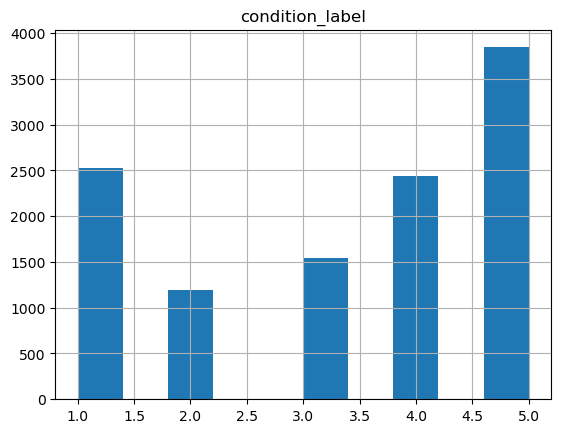

In [229]:
df.hist()

Перемешиваем датасет

In [230]:
df = shuffle(df)

Делим датасет на 2 части: первая - для ручной разметки, вторая - для разметки на основе правил.

In [231]:
manual_sample, rules_sample = train_test_split(df, train_size=0.01, random_state=42)

Сохраняем оба датасета в формате csv (для удобства дальнейшей работы)

Следующая ячейка кода необходима для сохранения исходного распределения датасета и предотвращения изменения количества строк и появления дубликатов при последующем объединении этих выборок после ручногй разметки в Label Studio и разметки на основе правил, которые взникали из-за неоднократного перезапуска всех ячеек в процессе работы (ручная разметка даже 115 статей занимает много времени).
В исходном варианте кода запись сплитованных датасетов осуществлялось сразу после их разделения.

In [236]:
exclude = pd.read_csv('ls_labeled.csv')
exclude.drop(['annotation_id', 'annotator', 'created_at', 'id', 'lead_time', 'updated_at', 'sentiment'], axis=1, inplace=True)
comon_sample = pd.concat([df, exclude])
manual_sample = comon_sample[comon_sample.duplicated()]
comon_sample.drop_duplicates(keep=False, inplace=True)
rules_sample = comon_sample

In [238]:
manual_sample.to_csv('manual_sample.csv', index=False)
rules_sample.to_csv('rules_sample.csv', index=False)

Проводим разметку на основе правил.

In [239]:
df_rule = pd.read_csv('rules_sample.csv')

In [240]:
df_rule.shape

(11435, 2)

In [241]:
neoplasms_list = ['neoplas', 'tumor', 'cancer', 'lymphom', 'blastoma', 'malign', 'benign', 'melanom', 'leukemi', 'metasta', 'carcinom', 'pheochromocytoma', 'teratoma', 'noma']

digestive_list = ['digestive', 'esophag', 'stomach', 'gastr', 'liver', 'cirrhosis', 'hepati', 'pancrea', 'intestin', 'sigmo', 'recto', 'rectu', 'cholecyst', 'gallbladder', 
                  'portal pressure', 'portal hypertension', 'appendic', 'ulcer', 'bowel']

neuro_list = ['neuro', 'nerv', 'reflex', 'brain', 'cerebr', 'white matter', 'subcort', 'plegi', 'intrathec', 'medulla', 'mening']

cardio_list = ['cardi', 'heart', 'vascul', 'embolism', 'stroke', 'reperfus', 'thromboly', 'ischemi', 'hypercholesterolemia', 'hyperten', 'blood pressure', 
               'valv', 'ventric', 'aneurysm', 'coronar', 'arter', 'aort', 'electrocardiogra', 'arrhythm', 'clot', 'mitral', 'endocard', 'hypertension', 'myocardial', 'infarction',
               'cardiover', 'fibrillat', 'bypass']

In [242]:
def rb_labeling(text):
    row = text.lower()
    res_dict = {
        'neoplasms': 0,
        'digestive system diseases': 0,
        'nervous system diseases': 0,
        'cardiovascular diseases': 0
    }
    for p in neoplasms_list:
        res_dict['neoplasms'] += row.count(p)
    for d in digestive_list:
        res_dict['digestive system diseases'] += row.count(d)
    for n in neuro_list:
        res_dict['nervous system diseases'] += row.count(n)
    for c in cardio_list:
        res_dict['cardiovascular diseases'] += row.count(c)
    
    most_frequent = max(res_dict.values())
    divisor = sum(res_dict.values())
    if divisor > 0 and (most_frequent / divisor) > 0.3:
        for key, value in res_dict.items(): 
            if value == most_frequent:
                return key
    else:
        return 'general pathological conditions'
    

In [243]:
df_rule['rule based condition name'] = df_rule['medical_abstract'].apply(rb_labeling)

In [244]:
df_rule.head()

,condition_label,medical_abstract,rule based condition name
0,4,The incidence of deep vein thrombosis after ce...,cardiovascular diseases
1,5,Adult height in boys and girls with untreated ...,general pathological conditions
2,5,Palliative treatment of bile duct tumoral comp...,neoplasms
3,5,Eclampsia. Early detection and hospitalization...,digestive system diseases
4,1,Efficacy of transesophageal echocardiography a...,cardiovascular diseases


Ручную разметку выборки выдержек из медицинских статей в размере 135 шт (0,01 от всего датасета) я провел с использованием Label Studio. 
Результат разметки сохранен в текущую директорию с именем ls_labeled.csv.

Далее необходимо объединить два размеченных датасета.
Для этого загрузим размеченный вручную датасет и посмотрим его структуру.

In [247]:
df_manual = pd.read_csv('ls_labeled.csv')
df_manual.head()

,annotation_id,annotator,condition_label,created_at,id,lead_time,medical_abstract,sentiment,updated_at
0,5,1,3,2024-04-06T20:17:30.099449Z,1,520.593,Quantifying language development from birth to...,nervous system diseases,2024-04-06T20:18:04.237342Z
1,6,1,3,2024-04-06T20:18:41.585714Z,2,10.603,Accessory arm--dysraphism or disparity? Case r...,digestive system diseases,2024-04-06T20:18:41.586826Z
2,7,1,1,2024-04-06T20:19:19.253793Z,3,30.304,The dichotomous distribution of gastrinomas. O...,neoplasms,2024-04-06T20:19:19.253793Z
3,8,1,5,2024-04-06T20:19:53.833237Z,4,26.009,Coronary angioplasty after coronary bypass sur...,cardiovascular diseases,2024-04-06T20:19:53.833237Z
4,9,1,4,2024-04-06T20:21:38.110782Z,5,101.586,A positron emission tomographic comparison of ...,general pathological conditions,2024-04-06T20:21:38.110782Z


Для объединения датасетов приведем датасет созданный label studio к соответствующему виду:

In [248]:
df_manual.drop(['annotation_id', 'annotator', 'created_at', 'id', 'lead_time', 'updated_at'], axis=1, inplace=True)
df_manual.head()

,condition_label,medical_abstract,sentiment
0,3,Quantifying language development from birth to...,nervous system diseases
1,3,Accessory arm--dysraphism or disparity? Case r...,digestive system diseases
2,1,The dichotomous distribution of gastrinomas. O...,neoplasms
3,5,Coronary angioplasty after coronary bypass sur...,cardiovascular diseases
4,4,A positron emission tomographic comparison of ...,general pathological conditions


Столбцы с выполненной разметкой в обоих датасетах назовем одинаково:

In [251]:
df_rule.rename(columns={'rule based condition name': 'labeled condition name'}, inplace=True)
df_manual.rename(columns={'sentiment': 'labeled condition name'}, inplace=True)

In [252]:
df_rule.head()

,condition_label,medical_abstract,labeled condition name
0,4,The incidence of deep vein thrombosis after ce...,cardiovascular diseases
1,5,Adult height in boys and girls with untreated ...,general pathological conditions
2,5,Palliative treatment of bile duct tumoral comp...,neoplasms
3,5,Eclampsia. Early detection and hospitalization...,digestive system diseases
4,1,Efficacy of transesophageal echocardiography a...,cardiovascular diseases


In [253]:
df_manual.head()

,condition_label,medical_abstract,labeled condition name
0,3,Quantifying language development from birth to...,nervous system diseases
1,3,Accessory arm--dysraphism or disparity? Case r...,digestive system diseases
2,1,The dichotomous distribution of gastrinomas. O...,neoplasms
3,5,Coronary angioplasty after coronary bypass sur...,cardiovascular diseases
4,4,A positron emission tomographic comparison of ...,general pathological conditions


Теперь объединим датасеты:

In [254]:
df_common = pd.concat([df_rule, df_manual])
df_common.head()

,condition_label,medical_abstract,labeled condition name
0,4,The incidence of deep vein thrombosis after ce...,cardiovascular diseases
1,5,Adult height in boys and girls with untreated ...,general pathological conditions
2,5,Palliative treatment of bile duct tumoral comp...,neoplasms
3,5,Eclampsia. Early detection and hospitalization...,digestive system diseases
4,1,Efficacy of transesophageal echocardiography a...,cardiovascular diseases


In [257]:
print(df_common.shape)
print(len(df_common[df_common.duplicated ()]))

(11550, 3)
0


В результирующем датасете сохранено количество строк и отсутствуют дубликаты

Для удобства дальнейшей работы переименуем колонку condition_label в old condition label,  а так же добавим числовые значения, соответствующие размеченным нами данным.

In [258]:
df_common.rename(columns={'condition_label': 'old condition label'}, inplace=True)
assessment_map = {"neoplasms": 1, "digestive system diseases": 2, "nervous system diseases": 3, "cardiovascular diseases": 4, "general pathological conditions": 5}
df_common['new condition label'] = df_common['labeled condition name'].map(assessment_map)

In [259]:
df_common.head()

,old condition label,medical_abstract,labeled condition name,new condition label
0,4,The incidence of deep vein thrombosis after ce...,cardiovascular diseases,4
1,5,Adult height in boys and girls with untreated ...,general pathological conditions,5
2,5,Palliative treatment of bile duct tumoral comp...,neoplasms,1
3,5,Eclampsia. Early detection and hospitalization...,digestive system diseases,2
4,1,Efficacy of transesophageal echocardiography a...,cardiovascular diseases,4
